In [40]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from PIL import Image
from tensorflow import keras
from tensorflow.keras import datasets,layers,optimizers,Sequential,metrics
import os
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical

TRAIN_DIR = "./dataset/dog vs cat/training_set/new"
TEST_DIR = "./dataset/dog vs cat/test_set/new"

In [41]:
def save_img(imgs,names):
  img_new = Image.new('L',(280,280))
  index = 0
  for i in range(0,280,80):
    for j in range(0,280,80):
      img = imgs[index]
      img = Image.fromarray(img,mode='L')
      img_new.paste(img,(i,j))
      index+=1
  img_new.save(names)

In [42]:
def feature_scale(x):
  x = tf.cast(x,dtype=tf.float32)/255.
#  y = tf.cast(y,dtype=tf.int32)
  return x

In [43]:
def feature_scale(x):
  x = tf.cast(x,dtype=tf.float32)/255.
#  y = tf.cast(y,dtype=tf.int32)
  return x

In [44]:
#Dim reduct nums
dim_reduce = 10
batch_num = 128
lr = 1e-3

In [45]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True)

In [80]:
filenames = os.listdir(TRAIN_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')

all_df = pd.DataFrame({
    'filename': filenames
})

test_filenames = os.listdir(TEST_DIR)
test_df = pd.DataFrame({
    'id': test_filenames
})

train_df, validate_df = train_test_split(all_df, test_size=0.20, random_state=0)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [97]:
sample_df = train_df.sample(n=1).reset_index(drop=True)
sample_generator = train_datagen.flow_from_dataframe(
    sample_df,
    TRAIN_DIR,
    x_col='filename',
    y_col='category',
    target_size = (32, 32),
    class_mode=None
)

Found 1 validated image filenames.


In [91]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    TRAIN_DIR,
    x_col='filename',
    y_col=None,
    target_size=(32, 32),
    batch_size=70,
    class_mode=None)

Found 6400 validated image filenames.


In [63]:
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_dataframe(
        validate_df, 
        TRAIN_DIR,
        x_col='filename',
        y_col='category',
        target_size=(64, 64),
        batch_size=70,
        class_mode='binary')

Found 1600 validated image filenames belonging to 2 classes.


In [92]:
test_generator = test_datagen.flow_from_dataframe(
        test_df, 
        TEST_DIR,
        x_col='id',
        y_col=None,
        class_mode=None,
        target_size=(32, 32),
        batch_size=12500//50)

Found 2000 validated image filenames.


In [109]:
k = train_generator
kt = test_generator

In [102]:
(x,y),(x_test,y_test) = datasets.fashion_mnist.load_data()
data = tf.data.Dataset.from_tensor_slices(x)
data = data.map(feature_scale).shuffle(10000).batch(128)

#print(data)
#print(next(iter(data)))
data_test = tf.data.Dataset.from_tensor_slices(x_test)
data_test = data_test.map(feature_scale).batch(128)
"""
data_iter = iter(data)
samples = next(data_iter)
print(samples.shape)
"""
data_iter = iter(k)
samples = next(data_iter)

len(samples)

70

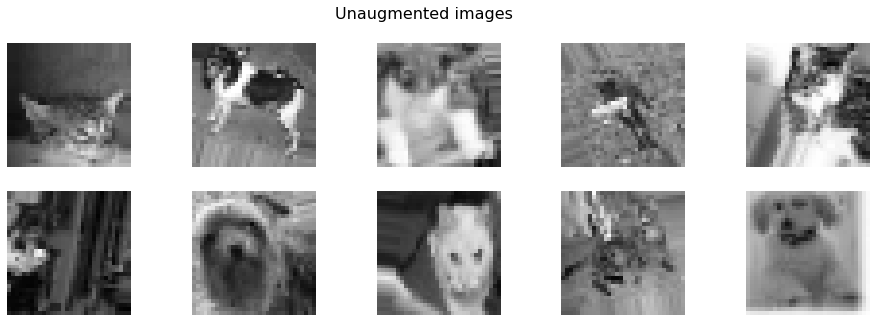

In [89]:
batch = next(train_generator)
batch_images = np.array(batch)

plt.figure(figsize=(16,5))
plt.suptitle("Unaugmented images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(batch_images[i])
    plt.axis('off')

In [22]:
class VAE(keras.Model):
  def __init__(self):
    super(VAE,self).__init__()
    #encoder
    self.fc_layer_1 = layers.Dense(128)
    self.fc_layer_2 = layers.Dense(256)
    self.fc_layer_3 = layers.Dense(256)
    self.fc_layer_4 = layers.Dense(512)
    self.fc_layer_5 = layers.Dense(1024)
    

  def model_encoder(self, x):
    h = tf.nn.relu(self.fc_layer_1(x))
    mean_fc = self.fc_layer_2(h)
    var_fc = self.fc_layer_3(h)
    return mean_fc,var_fc

  def model_decoder(self, z):
    out = tf.nn.relu(self.fc_layer_4(z))
    out = self.fc_layer_5(out)
    return out

  def reparameter(self,mean_x,var_x):
    eps = tf.random.normal(var_x.shape)
    std = tf.exp(var_x)**0.5
    z = mean_x + std*eps
    return z
  
  def call(self, inputs, training=None):
    mean_x,var_x = self.model_encoder(inputs)
    z = self.reparameter(mean_x,var_x)
    x = self.model_decoder(z)
    return x,mean_x,var_x

In [23]:
model = VAE()
model.build(input_shape=(1,1024))
optimizer = optimizers.Adam(lr=lr)
model.summary()
model.compile(optimizer = optimizer)

Model: "vae_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             multiple                  131200    
_________________________________________________________________
dense_21 (Dense)             multiple                  33024     
_________________________________________________________________
dense_22 (Dense)             multiple                  33024     
_________________________________________________________________
dense_23 (Dense)             multiple                  131584    
_________________________________________________________________
dense_24 (Dense)             multiple                  525312    
Total params: 854,144
Trainable params: 854,144
Non-trainable params: 0
_________________________________________________________________


In [ ]:
!rm -rf img_result
!mkdir img_result

In [106]:
print(iter(k))

In [112]:
optimizer = optimizers.Adam(lr=lr)
for i in range(1000):
    data_iter = iter(k)
    samples = next(data_iter)
    
    for x in iter(samples):
        x = tf.reshape(x,[-1,1024])
        with tf.GradientTape() as tape:
            logits,mean_x,var_x = model(x)
            loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x,logits=logits)
            loss = tf.reduce_sum(loss)/x.shape[0]
            kl_div = -0.5*(var_x+1-mean_x**2-tf.exp(var_x))
            kl_div = tf.reduce_sum(kl_div)/x.shape[0]
            
            loss = loss + 1.*kl_div
        grads = tape.gradient(loss,model.trainable_variables)
        optimizer.apply_gradients(zip(grads,model.trainable_variables))
        
        
        """if step %100==0:
            print(i,step,'loss:',float(loss),'kl_div:',float(kl_div))"""
            
    x = next(iter(kt))
    x = tf.reshape(new_x,[-1,1024])
    logits,_,_ = model(x)
    x_hat = tf.sigmoid(logits)
    x_hat = tf.reshape(x_hat,[-1,32,32])
    x_hat = x_hat.numpy()*255
    x_hat = x_hat.astype(np.uint8)
    
    if i%100==0:
        print(i,'loss:',float(loss),'kl_div:',float(kl_div))
        save_img(x_hat,'img_result/AE_img_%d.png'%i)

0 loss: 486.228515625 kl_div: 20.83652114868164
100 loss: 640.6310424804688 kl_div: 11.450762748718262
200 loss: 354.126708984375 kl_div: 19.380722045898438
300 loss: 711.0564575195312 kl_div: 10.523764610290527
400 loss: 664.1076049804688 kl_div: 11.43496036529541
500 loss: 599.5255126953125 kl_div: 14.445881843566895
600 loss: 651.960693359375 kl_div: 14.919670104980469
700 loss: 489.7490234375 kl_div: 13.57445240020752
800 loss: 689.1319580078125 kl_div: 11.66637897491455
900 loss: 685.9877319335938 kl_div: 13.177290916442871
